## Notenbonusprojekt
### Segmentierung von Stammkunden
** **

Für dieses Projekt liegen 200 Stammkundendaten vor. Es wird im Folgenden ein
Cluster-Algorithmus entwickelt, mit welchem dann die Segmentierung der Kunden
stattfindet. Daraus werden dann im Anschluss Handlungsempfehlungen abgeleitet.

** **

1. Um den Datensatz verwenden zu können, wird dieser zu Beginn eingelesen. Anschließend
werden die Attribute Alter, Jährliches Einkommen und Monatsausgaben standardisiert,
um im Späteren besser mit den Daten arbeiten zu können. Die Standardisierung erfolgt
mithilfe der _z-Transformation_ . Dies ist sinnvoll, da Daten in einem Datensatz
oftmals unterschiedlich skaliert sind. Die Transformation liefert eine einheitliche
Skalierung.

In [149]:
#Zu Beginn werden die Kundendaten mit dem Package Pandas eingelesen; importiere
#noch weiter wichtige Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, metrics



kunden = pd.read_csv('Kundendaten.csv', index_col= 0, delimiter=";", decimal=",")

#kunden = pd.get_dummies(kunden, columns=['Geschlecht'])


kunden.head()
kunden.rename(columns={'Alter':'Alter', 'Jährliches Einkommen (k€)':'Einkommen', 'Monatsausgaben (Indexwert, 1-100)':'Monatsausgaben'}, inplace = True)



for col in kunden.columns: #iteriert über alle Spalten im Datensatz
    if col == 'Geschlecht':
        continue
    kunden['z_' + col] = (kunden[col]-kunden[col].mean())/kunden[col].std()
X = kunden[['z_Alter', 'z_Einkommen', 'z_Monatsausgaben']].values #Variablen auswählen auf deren Basis klassifiziert werden soll


Die folgende Tabelle zeigt nun den Datensatz mit allen Werten. Es wurden die standardisierten
Werte hinzugefügt, welche mit einem __z__ beginnen und die Dummyvariable für _Geschlecht_.

In [126]:
#Dummy hinzugefügt für Geschlecht
#kunden['Dummy'] = kunden.Geschlecht.map( lambda Geschlecht: '1' if Geschlecht == 'Female' else '0')

kunden.head()
#print(X)

,Geschlecht,Alter,Einkommen,Monatsausgaben,z_Alter,z_Einkommen,z_Monatsausgaben
KundenID,,,,,,,
1,Male,19,15,39,-1.421003,-1.734646,-0.433713
2,Male,21,15,81,-1.277829,-1.734646,1.192711
3,Female,20,16,6,-1.349416,-1.696572,-1.711618
4,Female,23,16,77,-1.134655,-1.696572,1.037814
5,Female,31,17,40,-0.561958,-1.658498,-0.394989


2. Da wir nun die standardisierten Werte errechnet haben, können wir die erste Methode
zur Kundensegmentierung anwenden. Diese nennt sich die _Ellbogenmethode_ .

In [127]:

#Ellbogenmethode
ss = []
krange = list(range(1, 11)) #Hier einstellen, für welches Intervall die sum of squared errors berechnet werden soll
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[cluster_assignments]) ** 2))

C:\Users\mdrek\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Die Grafik zeigt nun das Ergebnis der _Ellbogenmethode_ . Wir sehen, dass bei k=6 die
Fehlerquadrate am wenigsten abfallen. Somit sollte laut dieser Methode das Clustering
für k=6 stattfinden. Dies prüfen wir nun noch mit einer anderen Methode. Diese wird
in __Abschnitt 3__ gezeigt.

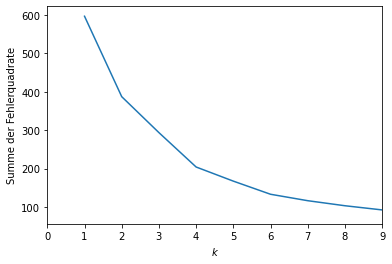

In [128]:
plt.plot(krange, ss)
plt.xlabel("$k$")
plt.ylabel("Summe der Fehlerquadrate")
plt.xlim(0,9)
plt.show()  #k=6


3. Es folgt nun die zweite Methode nach dem Silhouettenkoeffizient. Hier suchen wir ebenfalls das k nach dem
höchsten mittleren Silhouettenkoeffizienten. Dieser wird mithilfe einer _for-Schleife_
berechnet. Er gibt an, wie gut Cluster voneinander abgegrenz sind.
Anschließend wird das Ergebnis grafisch dargestellt.

In [129]:
#Silhouettenkoeffizient
krange = list(range(2, 11))
avg_silhouettes = []
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    silhouette_avg = metrics.silhouette_score(X, cluster_assignments)
    avg_silhouettes.append(silhouette_avg)

Die Grafik zeigt uns nun das Ergebnis der Berechnung. Wie schon bei der Ellbogenmethode,
ist auch hier wieder k=6. Somit ist k=6 basierend auf dem Silhouettenkoeffizienten
die beste Wahl.

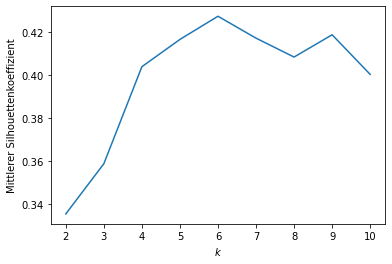

In [130]:
plt.plot(krange, avg_silhouettes)
plt.xlabel("$k$")
plt.ylabel("Mittlerer Silhouettenkoeffizient")
plt.show() #k = 6 ist basierend auf dem Silhouettenkoeffizienten die beste Wahl


** **

4. Die Methoden haben uns gezeigt, wie gut die Anzahl an Clustern
zu unseren Daten passt. Nun wird die k-Means-Methode angewandt. Wir nehmen dazu
k=6 wie oben bereits berechnet. Hierbei wird jede Dateninstanz dem nächstgelegenen
Clusterzentrum zugeordnet. Dies wird farblich in der Grafik dargestellt.

Die Grafik ist 3-Dimensional, wobei die Attribute das Alter, Einkommen
und die Montasausgaben sind.

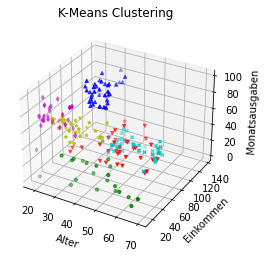

In [131]:
#k-Means Clustering

for n in [6]:
    model = cluster.KMeans(n_clusters=n, random_state=10)
    cluster_assignments = model.fit_predict(X)
    kunden['cluster']=model.labels_
    colors = ['b','g','m','red','y','c']
    markers = ['^','o','d','v','*','x']


    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    for c in kunden['cluster'].unique():
        d = kunden[kunden['cluster'] == c]
        xs = d['Alter']
        ys = d['Einkommen']
        zs = d['Monatsausgaben']
        ax.scatter(xs, ys, zs,marker=markers[c], color=colors[c], s=10)
    plt.title('K-Means Clustering')
    ax.set_xlabel('Alter')
    ax.set_ylabel('Einkommen')
    ax.set_zlabel('Monatsausgaben')

    plt.show()

### Auswertung der k-Means Methode
Hier sehen wir nun die 6 verschiedenen Cluster nach der k-Means Methode.


Die Grafik scheint jedoch noch etwas unübersichtlich, weshalb im Folgenden
die Methode des __DBSCAN__ angewandt wird. Hier werden Ausreißer nämlich _besser behandelt_.

** **

5. Wir nutzen nun die DBSCAN Methode für die Segmentierung.
Die folgende Grafik zeigt nun das Ergebnis des DBSCAN. Wir sehen deutlich 3 Cluster in Blau,
Lila und Grün. Die Gelben Dateninstanzen sind überall verteilt.

[-1  0  1  2  3]


IndexError: list index out of range

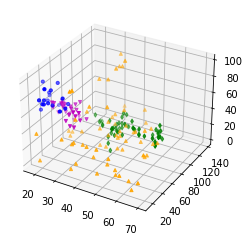

In [135]:

colors = ['orange','b','g','m']
markers = ['^','o','d','v']

model3=cluster.DBSCAN(eps=0.61,min_samples=11,metric='euclidean')#epsilon=0.61 und minsamples=11 bereits bestimmt durch Visualisierung
cluster_assignments3 = model3.fit_predict(X)
kunden['cluster3'] = model3.labels_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(kunden['cluster3'].unique())
for c in kunden['cluster3'].unique():
    d = kunden[kunden['cluster3'] == c]
    xs = d['Alter']
    ys = d['Einkommen']
    zs = d['Monatsausgaben']
    ax.scatter(xs, ys, zs,marker=markers[c+1], color=colors[c+1], s=10)

plt.title('DBSCAN Clustering')
ax.set_xlabel('Alter')
ax.set_ylabel('Einkommen')
ax.set_zlabel('Monatsausgaben')

plt.show()

** **
Wir haben nun einen Einblick in die Verteilung bekommen. Um nun bessere Aussagen
über die Kundensegmentierung zu erhalten, führen wir das Clustering nun nach
Geschlecht durch.
** **

5.1 DBSCAN für Frauen

In [165]:
#Neue Tabellen für Female

kunden2 = pd.read_csv('Kundendaten.csv', index_col= 0, delimiter=";", decimal=",")

#kunden = pd.get_dummies(kunden, columns=['Geschlecht'])


kunden2.head()
kunden2.rename(columns={'Alter':'Alter', 'Jährliches Einkommen (k€)':'Einkommen', 'Monatsausgaben (Indexwert, 1-100)':'Monatsausgaben'}, inplace = True)

female = kunden2.loc[kunden2["Geschlecht"] == 'Female']
for col in female.columns: #iteriert über alle Spalten im Datensatz
    if col == 'Geschlecht':
        continue
    female['z_' + col] = (female[col]-female[col].mean())/female[col].std()
X_female = female[['z_Alter', 'z_Einkommen', 'z_Monatsausgaben']].values #Variablen auswählen auf deren Basis klassifiziert werden soll

C:\Users\mdrek\AppData\Local\Temp/ipykernel_9168/558874.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female['z_' + col] = (female[col]-female[col].mean())/female[col].std()


In [166]:
female.head()

,Geschlecht,Alter,Einkommen,Monatsausgaben,z_Alter,z_Einkommen,z_Monatsausgaben
KundenID,,,,,,,
3,Female,20,16,6,-1.431357,-1.662697,-1.887907
4,Female,23,16,77,-1.194092,-1.662697,1.056325
5,Female,31,17,40,-0.561386,-1.624253,-0.477993
6,Female,22,17,76,-1.273180,-1.624253,1.014857
7,Female,35,18,6,-0.245032,-1.585810,-1.887907


[-1  0  1]


C:\Users\mdrek\AppData\Local\Temp/ipykernel_9168/3665573392.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female['cluster4'] = model4.labels_


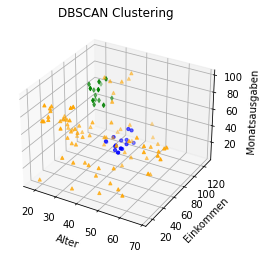

In [167]:
##DBSCAN für female

colors = ['orange','b','g','m']
markers = ['^','o','d','v']

model4=cluster.DBSCAN(eps=0.61,min_samples=11,metric='euclidean')#epsilon=0.61 und minsamples=11 bereits bestimmt durch Visualisierung
cluster_assignments4 = model4.fit_predict(X_female)
female['cluster4'] = model4.labels_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(female['cluster4'].unique())
for c in female['cluster4'].unique():
    d = female[female['cluster4'] == c]
    xs = d['Alter']
    ys = d['Einkommen']
    zs = d['Monatsausgaben']
    ax.scatter(xs, ys, zs,marker=markers[c+1], color=colors[c+1], s=10)

plt.title('DBSCAN Clustering für Frauen')
ax.set_xlabel('Alter')
ax.set_ylabel('Einkommen')
ax.set_zlabel('Monatsausgaben')

plt.show()

In der obigen Grafik ist nun die Methode des DBSCAN nur für Frauen zu sehen. Hier erkennen wir
3 CLuster. Ein grünes Cluster, welches Frauen mit hohem Einkommen und hohen Monatsausgaben zeigt.
Diese sind auch eher jünger und befinden sich im Bereich der 20 - 30 Jährigen.

Ein anderes Cluster befindet sich im Bereich der 40 Jährigen mit mittleren Ausgaben und eher
geringerem Einkommen.

Die anderen Dateninstanzen, in der Grafik Gelb gekennzeichnet, sind überall verteilt und keinem
der beiden Cluster direkt zuzuordnen.
** **

5.2 DBSCAN für Männer

In [ ]:
#Neue Tabellen für Male

kunden3 = pd.read_csv('Kundendaten.csv', index_col= 0, delimiter=";", decimal=",")

#kunden = pd.get_dummies(kunden, columns=['Geschlecht'])


kunden3.head()
kunden3.rename(columns={'Alter':'Alter', 'Jährliches Einkommen (k€)':'Einkommen', 'Monatsausgaben (Indexwert, 1-100)':'Monatsausgaben'}, inplace = True)

male = kunden3.loc[kunden3["Geschlecht"] == 'Male']
for col in male.columns: #iteriert über alle Spalten im Datensatz
    if col == 'Geschlecht':
        continue
    male['z_' + col] = (male[col]-male[col].mean())/male[col].std()
X_male = male[['z_Alter', 'z_Einkommen', 'z_Monatsausgaben']].values #Variablen auswählen auf deren Basis klassifiziert werden soll

In [169]:
male.head()

,Geschlecht,Alter,Einkommen,Monatsausgaben,z_Alter,z_Einkommen,z_Monatsausgaben
KundenID,,,,,,,
1,Male,19,15,39,-1.341094,-1.772904,-0.340949
2,Male,21,15,81,-1.212185,-1.772904,1.164602
9,Male,64,19,3,1.559360,-1.622744,-1.631421
11,Male,67,19,14,1.752724,-1.622744,-1.237110
15,Male,37,20,13,-0.180912,-1.585205,-1.272956


[-1]


C:\Users\mdrek\AppData\Local\Temp/ipykernel_9168/4225853491.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male['cluster5'] = model5.labels_


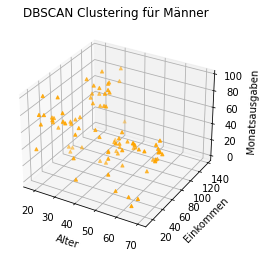

In [170]:
##DBSCAN für female

colors = ['orange','b','g','m']
markers = ['^','o','d','v']

model5=cluster.DBSCAN(eps=0.61,min_samples=11,metric='euclidean')#epsilon=0.61 und minsamples=11 bereits bestimmt durch Visualisierung
cluster_assignments5 = model5.fit_predict(X_male)
male['cluster5'] = model5.labels_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(male['cluster5'].unique())
for c in male['cluster5'].unique():
    d = male[male['cluster5'] == c]
    xs = d['Alter']
    ys = d['Einkommen']
    zs = d['Monatsausgaben']
    ax.scatter(xs, ys, zs,marker=markers[c+1], color=colors[c+1], s=10)

plt.title('DBSCAN Clustering für Männer')
ax.set_xlabel('Alter')
ax.set_ylabel('Einkommen')
ax.set_zlabel('Monatsausgaben')

plt.show()

Hier sind keine Cluster anhand des DBSCAN erkennbar. Alle Dateninstanzen sind verteilt. Es ist
hier also kein bestimmtes Cluster zu erkennen. Dies führt nun dazu, dass wir eine andere Methode
zur Kundensegmentierung anwenden müssen.
** **

6. Nehmen wir nun nochmals das k-Means Clustering Verfahren zur Hand. Diesmal ebenfalls unterteilt
in Frauen und Männer.
7.
6.1 Zuerst schauen wir uns die Frauen an und nehmen wie bereits am Anfang k=6.

C:\Users\mdrek\AppData\Local\Temp/ipykernel_9168/1721639857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female['cluster6']=model6.labels_


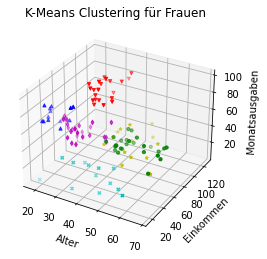

In [171]:
#k-Means Clustering für Frauen

for n in [6]:
    model6 = cluster.KMeans(n_clusters=n, random_state=10)
    cluster_assignments6 = model6.fit_predict(X_female)
    female['cluster6']=model6.labels_
    colors = ['b','g','m','red','y','c']
    markers = ['^','o','d','v','*','x']


    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    for c in female['cluster6'].unique():
        d = female[female['cluster6'] == c]
        xs = d['Alter']
        ys = d['Einkommen']
        zs = d['Monatsausgaben']
        ax.scatter(xs, ys, zs,marker=markers[c], color=colors[c], s=10)
    plt.title('K-Means Clustering für Frauen')
    ax.set_xlabel('Alter')
    ax.set_ylabel('Einkommen')
    ax.set_zlabel('Monatsausgaben')

    plt.show()

Interpretation:


6.2 Schauen wir uns nun nochmals das Clustering für Männer an:

C:\Users\mdrek\AppData\Local\Temp/ipykernel_9168/339225073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male['cluster7']=model7.labels_


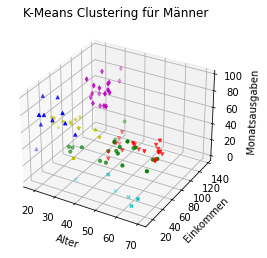

In [173]:
#k-Means Clustering für Männer

for n in [6]:
    model7 = cluster.KMeans(n_clusters=n, random_state=10)
    cluster_assignments7 = model7.fit_predict(X_male)
    male['cluster7']=model7.labels_
    colors = ['b','g','m','red','y','c']
    markers = ['^','o','d','v','*','x']


    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    for c in male['cluster7'].unique():
        d = male[male['cluster7'] == c]
        xs = d['Alter']
        ys = d['Einkommen']
        zs = d['Monatsausgaben']
        ax.scatter(xs, ys, zs,marker=markers[c], color=colors[c], s=10)
    plt.title('K-Means Clustering für Männer')
    ax.set_xlabel('Alter')
    ax.set_ylabel('Einkommen')
    ax.set_zlabel('Monatsausgaben')

    plt.show()




Interpretation:
